## LDA 토픽 모델링을 기반으로 한 무신사(신발 카테고리 한정) 리뷰 탐색적 분석
#### 무신사 신발 리뷰 분석을 통해 소비자의 만족 유발 요인은 무엇인가? 반대로 불만족 요인은 무엇인가?
-  토픽 모델링이란
    - 문서 집합에서 주제를 찾아내기 위한 기술
    - 특정 주제에 관한 문서에는  특정 단어가 자주 등장할 것이다라는 직관을 기반으로 한다.
    - 잠재의미분석과 잠재디리클레 할당 기법이 있다.
- LDA


In [1]:
# 필요한 라이브러리 설치
import pandas as pd
from konlpy.tag import Okt
from tqdm import tqdm
from konlpy.tag import Mecab
from tqdm import tqdm
import re
import pickle
import csv
from pandas import DataFrame 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [2]:
# 데이터 불러오기 ## 다른 리뷰데이터 concat 필요
musinsa=pd.read_csv('review_page4.csv')
musinsa.head()

,Unnamed: 0,name,date,product,detail,score,review,help_cnt,style_cnt,type,category,sex,price,tag
0,0,LV.6 슈나우뎌,2023.04.19,샨티 슬라이드 Merlot,230,3.0,어디에도 안써져있지만 발바닥 핑크색 이염있습니다 신다보면 흰양말이 연분홍색으로 물들...,16,1.0,style,슬리퍼,"남성, 여성",99000,"사이즈-작아요, 밝기-보통이에요, 색감-선명해요, 발볼-보통이에요, 착화감-적당해요..."
1,1,LV.5 쀼쮸뿌쮸,2023.05.15,샨티 슬라이드 Merlot,240,5.0,킨 신발 너무 편하게 신고있어서 슬리퍼도 사봤는데 너무 편해요! 그냥 푹신한게 아니...,4,0.0,style,슬리퍼,"남성, 여성",99000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-편..."
2,2,LV.5 야ㅏ니,2023.05.01,샨티 슬라이드 Merlot,250,5.0,귀엽고 마음에 듭니다요 다만 저는 운동화 235 신는 사람인데 250이 편하게 맞는...,1,2.0,style,슬리퍼,"남성, 여성",99000,"사이즈-작아요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-편안해..."
3,3,LV.5 도망가자나랑,2023.05.21,샨티 슬라이드 Merlot,250,5.0,야호 넘 귀여워용 앞으로 제 여름신발 담당임다 근데 사이즈 작게 나왔으니 다들 꼭 ...,0,2.0,style,슬리퍼,"남성, 여성",99000,"사이즈-작아요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적당해..."
4,4,LV.5 옘주형,2023.07.18,샨티 슬라이드 Merlot,240,5.0,길이만 작게 나오고 볼이랑 등은 크게 나옴\n발바닥은 면이라 물에는 못들어갈듯,1,0.0,style,슬리퍼,"남성, 여성",99000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-넓어요, 착화감-편안해..."


In [3]:
#필요한 컬럼만 추출
musinsa.drop(['name','date','style_cnt','price'],axis=1,inplace=True)
musinsa['sex']=musinsa['sex'].replace({'남성, 여성':'남녀공용'})

In [5]:
# 상품 별 몇 개의 행이 있는지 count
element_count={}

for item in musinsa['product']:
    element_count.setdefault(item,0)
    element_count[item]+=1

product_count=pd.DataFrame.from_dict(element_count,orient='index',columns=['product_count'])
product_count

,product_count
샨티 슬라이드 Merlot,49
미니멀 플립플랍 (블랙),7288
오피스 슬라이드 레더 블랙 547,4564
[슈펜X마하그리드] 베이직 슬라이드 AFDU78S33,1018
(샤틴안감/기모안감) 라운드 토 메리제인 플랫 (1cm/4colors+3colors),247
[WOMEN] 오리지날 플레이 숏 레인부츠 - 블랙 WFS2020RMABLK,499
클래식 페니 로퍼 [블랙],153
펜톤 벡스 스퀘어 블랙 / 31303001,14
제타 리커버리 슬라이드 [블랙],31
Strap Embossed Toe Shoes / Silver,77


In [6]:
# 한글이 아니면 빈 문자열로 변환
musinsa.review=musinsa.review.astype(str)
musinsa['review'] = musinsa['review'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',regex=True)

print(musinsa.isnull().values.any())

False


## 평점을 기준으로 긍정, 부정 데이터 분리
- 평점 5점인 경우 긍정, 그 미만은 부정으로 분리하였다.

In [7]:
# 긍정
musinsa_pos=musinsa[musinsa['score']>4.0]
# 부정
musinsa_neg=musinsa[musinsa['score']<=4.0]

## 데이터 토큰화 진행
- 단어와 어절 등 의미를 가지는 문자열 단위로 쪼개기 tokenization
    - 형태소 분석 과정 Morphological Analysis 과 품사태깅과정 part of speech Tagging
    - 동의어는 한 단어로 처리하기, 동떨어진 개념이라 판단되는 단어와 형태소 등은 제거하기
#### 참고: 다양한 형태소 분석기를 사용하여 성능을 비교할 필요성이 있다.

In [8]:
# tokenization
## 정규 표현식으로 데이터 전처리
musinsa_neg['preprocessed']=musinsa_neg['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
musinsa_neg['preprocessed']=musinsa_neg['preprocessed'].str.replace("\n", "")
musinsa_neg['preprocessed']=musinsa_neg['preprocessed'].str.replace(" +", " ") # 다중 공백 제거

C:\Users\jk032\AppData\Local\Temp\ipykernel_30748\4180733520.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musinsa_neg['preprocessed']=musinsa_neg['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\jk032\AppData\Local\Temp\ipykernel_30748\4180733520.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musinsa_neg['preprocessed']=musinsa_neg['preprocessed'].str.replace("\n", "")
C:\Users\jk032\AppData\Local\Temp\ipykernel_30748\4180733520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a c

In [9]:
musinsa_neg.head()

,Unnamed: 0,product,detail,score,review,help_cnt,type,category,sex,tag,preprocessed
0,0,샨티 슬라이드 Merlot,230,3.0,어디에도 안써져있지만 발바닥 핑크색 이염있습니다 신다보면 흰양말이 연분홍색으로 물들...,16,style,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-선명해요, 발볼-보통이에요, 착화감-적당해요...",어디에도 안써져있지만 발바닥 핑크색 이염있습니다 신다보면 흰양말이 연분홍색으로 물들...
9,0,샨티 슬라이드 Merlot,270,4.0,발볼 넓은편이고 사이즈이지만 주문 하니 사이즈맞아요 편하고 좋은데 ...,2,product,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-선명해요, 발볼-좁아요, 착화감-적당해요, ...",발볼 넓은편이고 사이즈이지만 주문 하니 사이즈맞아요 편하고 좋은데 ...
13,4,샨티 슬라이드 Merlot,240,4.0,기야워요 흰색이랑 고민했는데 핑크하길잘한거같아요 포인트주기도 좋고 흰색양말이랑 신어...,1,product,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적당해...",기야워요 흰색이랑 고민했는데 핑크하길잘한거같아요 포인트주기도 좋고 흰색양말이랑 신어...
14,5,샨티 슬라이드 Merlot,250,4.0,맨발로는 좀 불편해오 ㅠㅠ 색은 귀여워요 이를 어쩜 좋아,1,product,슬리퍼,남녀공용,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",맨발로는 좀 불편해오 ㅠㅠ 색은 귀여워요 이를 어쩜 좋아
36,12,샨티 슬라이드 Merlot,250,4.0,맨빌로 신기엔 발등이 너무 아파요 ㅠㅠ 사이즈는 평소 신는데 ...,0,general,슬리퍼,남녀공용,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",맨빌로 신기엔 발등이 너무 아파요 ㅠㅠ 사이즈는 평소 신는데 ...


In [10]:
# pos : 형태소에 품사를 붙여서 추출
# morphs :  형태소만 추출
# nouns: 명사 추출
mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

##  morphs : 형태소만 추출
tokenized=[]
for sentenced in musinsa_neg['review']:
    tokens=mecab.morphs(sentenced)
    tokenize=' '.join(tokens)
    tokenized.append(tokenize)
musinsa_neg['tokenized_review']=pd.DataFrame(tokenized)

musinsa_neg.head()

C:\Users\jk032\AppData\Local\Temp\ipykernel_30748\145483394.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musinsa_neg['tokenized_review']=pd.DataFrame(tokenized)


,Unnamed: 0,product,detail,score,review,help_cnt,type,category,sex,tag,preprocessed,tokenized_review
0,0,샨티 슬라이드 Merlot,230,3.0,어디에도 안써져있지만 발바닥 핑크색 이염있습니다 신다보면 흰양말이 연분홍색으로 물들...,16,style,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-선명해요, 발볼-보통이에요, 착화감-적당해요...",어디에도 안써져있지만 발바닥 핑크색 이염있습니다 신다보면 흰양말이 연분홍색으로 물들...,어디 에 도 안 써져 있 지만 발바닥 핑크 색 이염 있 습니다 신 다 보 면 흰 양...
9,0,샨티 슬라이드 Merlot,270,4.0,발볼 넓은편이고 사이즈이지만 주문 하니 사이즈맞아요 편하고 좋은데 ...,2,product,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-선명해요, 발볼-좁아요, 착화감-적당해요, ...",발볼 넓은편이고 사이즈이지만 주문 하니 사이즈맞아요 편하고 좋은데 ...,예쁜데 엄지 잡 아 주 는 끈 이 잡 아 주 는데 너무 아프 네요 고무 면 모를까 ...
13,4,샨티 슬라이드 Merlot,240,4.0,기야워요 흰색이랑 고민했는데 핑크하길잘한거같아요 포인트주기도 좋고 흰색양말이랑 신어...,1,product,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적당해...",기야워요 흰색이랑 고민했는데 핑크하길잘한거같아요 포인트주기도 좋고 흰색양말이랑 신어...,쿠션 감 이 있 어서 뛸 때 도 무릎 에 무리 가 가 지 않 아서 좋 아요 대신 발...
14,5,샨티 슬라이드 Merlot,250,4.0,맨발로는 좀 불편해오 ㅠㅠ 색은 귀여워요 이를 어쩜 좋아,1,product,슬리퍼,남녀공용,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",맨발로는 좀 불편해오 ㅠㅠ 색은 귀여워요 이를 어쩜 좋아,푹신 하 고 예뻐요 신 는데 사이즈 딱 좋 아요 가운데 끈 은 엄청 아파요
36,12,샨티 슬라이드 Merlot,250,4.0,맨빌로 신기엔 발등이 너무 아파요 ㅠㅠ 사이즈는 평소 신는데 ...,0,general,슬리퍼,남녀공용,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",맨빌로 신기엔 발등이 너무 아파요 ㅠㅠ 사이즈는 평소 신는데 ...,커플 신발 로 장만 했 는데 여름 요긴 하 게 신 을 것 같 아요 처음 신 은 날 ...


In [11]:
## pos : 형태소에 품사를 붙여서 추출
# 우선 NNG,NNP,NNB,NNBC,NR,NP,VV,VA,VX,VCP,VCN,MM,MAG,MAJ,XPN,XR 에 해당하는 품사만 가지고 왔다(변경해야 할 필요성 존재)
main_pos=[]
for sentence in musinsa_neg['review']:
    pos=mecab.pos(sentence)
    main_words=[word_pos[0] for word_pos in pos if word_pos[1] in ('NNG','NNP','NNB','NNBC','NR','NP','VV','VA','VX','VCP','VCN','MM','MAG','MAJ','XPN','XR')]
    main_words_str= ' '.join(main_words)
    main_pos.append(main_words_str)
musinsa_neg['main_pos']=pd.DataFrame(main_pos)

musinsa_neg.head() # 맨발을 맨빌로 표현하는 경우 있음, 이런거 찾아서 통일시켜야 할 필요가 보인다.

C:\Users\jk032\AppData\Local\Temp\ipykernel_30748\63754156.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musinsa_neg['main_pos']=pd.DataFrame(main_pos)


,Unnamed: 0,product,detail,score,review,help_cnt,type,category,sex,tag,preprocessed,tokenized_review,main_pos
0,0,샨티 슬라이드 Merlot,230,3.0,어디에도 안써져있지만 발바닥 핑크색 이염있습니다 신다보면 흰양말이 연분홍색으로 물들...,16,style,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-선명해요, 발볼-보통이에요, 착화감-적당해요...",어디에도 안써져있지만 발바닥 핑크색 이염있습니다 신다보면 흰양말이 연분홍색으로 물들...,어디 에 도 안 써져 있 지만 발바닥 핑크 색 이염 있 습니다 신 다 보 면 흰 양...,어디 안 있 발바닥 핑크 색 이염 있 신 보 양말 연분홍색 물들 신 보 이염 데 때...
9,0,샨티 슬라이드 Merlot,270,4.0,발볼 넓은편이고 사이즈이지만 주문 하니 사이즈맞아요 편하고 좋은데 ...,2,product,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-선명해요, 발볼-좁아요, 착화감-적당해요, ...",발볼 넓은편이고 사이즈이지만 주문 하니 사이즈맞아요 편하고 좋은데 ...,예쁜데 엄지 잡 아 주 는 끈 이 잡 아 주 는데 너무 아프 네요 고무 면 모를까 ...,엄지 잡 주 끈 잡 주 너무 아프 고무 하루 신 상처 사이즈 딱 맞 하 슬프
13,4,샨티 슬라이드 Merlot,240,4.0,기야워요 흰색이랑 고민했는데 핑크하길잘한거같아요 포인트주기도 좋고 흰색양말이랑 신어...,1,product,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적당해...",기야워요 흰색이랑 고민했는데 핑크하길잘한거같아요 포인트주기도 좋고 흰색양말이랑 신어...,쿠션 감 이 있 어서 뛸 때 도 무릎 에 무리 가 가 지 않 아서 좋 아요 대신 발...,쿠션 있 때 무릎 무리 가 않 좋 대신 발등 좀 아프
14,5,샨티 슬라이드 Merlot,250,4.0,맨발로는 좀 불편해오 ㅠㅠ 색은 귀여워요 이를 어쩜 좋아,1,product,슬리퍼,남녀공용,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",맨발로는 좀 불편해오 ㅠㅠ 색은 귀여워요 이를 어쩜 좋아,푹신 하 고 예뻐요 신 는데 사이즈 딱 좋 아요 가운데 끈 은 엄청 아파요,푹신 신 사이즈 딱 좋 가운데 끈 엄청
36,12,샨티 슬라이드 Merlot,250,4.0,맨빌로 신기엔 발등이 너무 아파요 ㅠㅠ 사이즈는 평소 신는데 ...,0,general,슬리퍼,남녀공용,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",맨빌로 신기엔 발등이 너무 아파요 ㅠㅠ 사이즈는 평소 신는데 ...,커플 신발 로 장만 했 는데 여름 요긴 하 게 신 을 것 같 아요 처음 신 은 날 ...,커플 신발 장만 여름 요긴 신 것 같 처음 신 날 살짝 쓸리 두 번 신 잘 신 있 ...


In [16]:
## nouns: 명사 추출
mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

tokenized=[]
for sentenced in musinsa_neg['review']:
    tokens=mecab.nouns(sentenced)
    tokenize=' '.join(tokens) #tokenize=' '.join(tokens)
    tokenized.append(tokenize)
    
musinsa_neg['nouns_review']=pd.DataFrame(tokenized)

musinsa_neg.head()


C:\Users\jk032\AppData\Local\Temp\ipykernel_30748\1445594731.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musinsa_neg['nouns_review']=pd.DataFrame(tokenized)


,Unnamed: 0,product,detail,score,review,help_cnt,type,category,sex,tag,preprocessed,tokenized_review,main_pos,nouns_review
0,0,샨티 슬라이드 Merlot,230,3.0,어디에도 안써져있지만 발바닥 핑크색 이염있습니다 신다보면 흰양말이 연분홍색으로 물들...,16,style,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-선명해요, 발볼-보통이에요, 착화감-적당해요...",어디에도 안써져있지만 발바닥 핑크색 이염있습니다 신다보면 흰양말이 연분홍색으로 물들...,어디 에 도 안 써져 있 지만 발바닥 핑크 색 이염 있 습니다 신 다 보 면 흰 양...,어디 안 있 발바닥 핑크 색 이염 있 신 보 양말 연분홍색 물들 신 보 이염 데 때...,어디 발바닥 핑크 색 이염 양말 연분홍색 이염 데 때 양말 개정 기도 건 어니 분홍...
9,0,샨티 슬라이드 Merlot,270,4.0,발볼 넓은편이고 사이즈이지만 주문 하니 사이즈맞아요 편하고 좋은데 ...,2,product,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-선명해요, 발볼-좁아요, 착화감-적당해요, ...",발볼 넓은편이고 사이즈이지만 주문 하니 사이즈맞아요 편하고 좋은데 ...,예쁜데 엄지 잡 아 주 는 끈 이 잡 아 주 는데 너무 아프 네요 고무 면 모를까 ...,엄지 잡 주 끈 잡 주 너무 아프 고무 하루 신 상처 사이즈 딱 맞 하 슬프,엄지 끈 고무 하루 상처 인데 사이즈
13,4,샨티 슬라이드 Merlot,240,4.0,기야워요 흰색이랑 고민했는데 핑크하길잘한거같아요 포인트주기도 좋고 흰색양말이랑 신어...,1,product,슬리퍼,남녀공용,"사이즈-작아요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적당해...",기야워요 흰색이랑 고민했는데 핑크하길잘한거같아요 포인트주기도 좋고 흰색양말이랑 신어...,쿠션 감 이 있 어서 뛸 때 도 무릎 에 무리 가 가 지 않 아서 좋 아요 대신 발...,쿠션 있 때 무릎 무리 가 않 좋 대신 발등 좀 아프,쿠션 때 무릎 무리 대신 발등
14,5,샨티 슬라이드 Merlot,250,4.0,맨발로는 좀 불편해오 ㅠㅠ 색은 귀여워요 이를 어쩜 좋아,1,product,슬리퍼,남녀공용,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",맨발로는 좀 불편해오 ㅠㅠ 색은 귀여워요 이를 어쩜 좋아,푹신 하 고 예뻐요 신 는데 사이즈 딱 좋 아요 가운데 끈 은 엄청 아파요,푹신 신 사이즈 딱 좋 가운데 끈 엄청,푹신 사이즈 가운데 끈
36,12,샨티 슬라이드 Merlot,250,4.0,맨빌로 신기엔 발등이 너무 아파요 ㅠㅠ 사이즈는 평소 신는데 ...,0,general,슬리퍼,남녀공용,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",맨빌로 신기엔 발등이 너무 아파요 ㅠㅠ 사이즈는 평소 신는데 ...,커플 신발 로 장만 했 는데 여름 요긴 하 게 신 을 것 같 아요 처음 신 은 날 ...,커플 신발 장만 여름 요긴 신 것 같 처음 신 날 살짝 쓸리 두 번 신 잘 신 있 ...,커플 신발 장만 여름 것 날 번 땐 무게 안정 굽 키


## 어휘 분석 Lexicon Analysis
데이터 내에서 어떤 특정 단어들이 많이 등장하는지 빈도 분석을 통해 살펴 본다.
- 워드 클라우드
- TD-IDF:  단어의 상대적인 중요성을 고려하여 문서 간 비교 및 검색 성능을 향상시킨다. 빈도수 기반으로 주요 단어를 잡아주는 방법 counter vectorizer 라 하며, 의미 없는 단어에 대한 패널티를 주어 중요한 단어를 감지한다는 것이 핵심
    - 장점: 직관적 해석이 가능함. 단어의 상대적 중요성을 고려하여 추천할 수 있다.
    - 단점: 대규모 데이터에서 메모리 문제 발생 가능성(우리의 데이터 경우 10만개가 넘기때문에 사용 고려해보아야 함)

In [26]:
#워드 클라우드
stopwords=set(['것','생각','신발','발','발등','구매','여름','느낌','사이즈','때문','번','거','신','정도','게','등','제','부분','수','듯',
               '때','느낌','생각','사이즈','편','가락','사이','고','디자인','생각','슬리퍼','데','저','지','나','nan'])

musinsa_neg['nouns_review'] = musinsa_neg['nouns_review'].astype(str)

musinsa_neg['filtered_nouns_review'] = musinsa_neg['nouns_review'].apply(lambda x: [word for word in x.split() if word not in stopwords])
all_nouns=' '.join([''.join(nouns) for nouns in musinsa_neg['filtered_nouns_review']])



C:\Users\jk032\AppData\Local\Temp\ipykernel_30748\165462881.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musinsa_neg['nouns_review'] = musinsa_neg['nouns_review'].astype(str)
C:\Users\jk032\AppData\Local\Temp\ipykernel_30748\165462881.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musinsa_neg['filtered_nouns_review'] = musinsa_neg['nouns_review'].apply(lambda x: [word for word in x.split() if word not in stopwords])


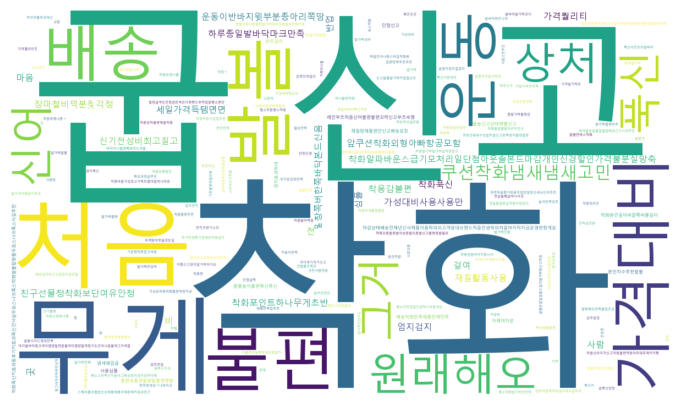

In [28]:
from wordcloud import WordCloud
font_path = 'C:/Windows/Fonts/malgun.ttf'
# 워드클라우드 생성
wordcloud = WordCloud(font_path=font_path,width=1200, height=700, background_color='white').generate(all_nouns)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show() # stopword를 설정해주었음에도 계속 단어가 나타남. #단어가 제대로 안나누어짐..
        # 워드클라우드를 통해 발볼, 배송, 불만족, 쿠션, 냄새, 착화감 등의 단어가 많이 언급됨을 알 수 있었다.

In [29]:
# TD-IDF
## 원하는 결과: 상위 키워드 파악하기 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(musinsa_neg.nouns_review)

# tf-idf 수행
print(tfidf_matrix.shape) # shape : 데이터의 개수 8177, 유니크한 단어들 개수 2805

(8177, 1298)


In [30]:
#코사인 유사도 
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

## LDA 토픽 모델링
- 최적의 토픽 개수 추출 -> 임의의 토픽 개수 선정보다는 퍼플렉시티 이용
- LDA 시각화

In [31]:
neg_df=musinsa[musinsa['score']<=4.0]
neg_df=neg_df[['review']]
neg_df.reset_index(drop=True, inplace=True)
neg_df.head()

,review
0,어디에도 안써져있지만 발바닥 핑크색 이염있습니다 신다보면 흰양말이 연분홍색으로 물들...
1,발볼 넓은편이고 사이즈이지만 주문 하니 사이즈맞아요 편하고 좋은데 ...
2,기야워요 흰색이랑 고민했는데 핑크하길잘한거같아요 포인트주기도 좋고 흰색양말이랑 신어...
3,맨발로는 좀 불편해오 ㅠㅠ 색은 귀여워요 이를 어쩜 좋아
4,맨빌로 신기엔 발등이 너무 아파요 ㅠㅠ 사이즈는 평소 신는데 ...


In [32]:
# Okt 형태소 분석기 초기화
okt = Okt()

# 토큰화 함수 정의
def tokenize(text):
    tokens = okt.pos(text)
    # 명사만 추출
    tokens = [token[0] for token in tokens if token[1] == 'Noun']
    return tokens

# 리뷰 토큰화
neg_df['review'] = neg_df['review'].apply(tokenize)

print(neg_df)

                                                 review
0     [어디, 발바닥, 핑크색, 이염, 양말, 분홍색, 이염, 때, 머, 일단, 양말, ...
1     [발볼, 편이, 사이즈, 주문, 하니, 사이즈, 맨발, 엄지발가락, 쪽, 부분, 신...
2        [기, 워, 흰색, 고민, 핑크, 거, 포인트, 주기도, 흰색, 양말, 신어, 여]
3                                    [맨발, 좀, 불편, 색, 어쩜]
4                          [맨, 신기, 발등, 사이즈, 평소, 양말, 신고]
...                                                 ...
8172  [보통, 사이즈, 업, 신발, 가격, 마감, 할인, 쿠폰, 살, 수, 그냥, 신어,...
8173  [주로, 신어, 리뷰, 감안, 업, 느낌, 드네, 교환, 사이즈, 그냥, 신어, 신...
8174                             [사이즈, 작고, 재질, 디자인, 색도]
8175                               [운동화, 사이즈, 은, 완전, 요]
8176                        [배송, 포장, 사이즈, 좀, 해, 사이즈, 업]

[8177 rows x 1 columns]


In [33]:
# 리스트형 변환
dff=neg_df['review'].values.tolist()
dff[:5]

[['어디',
  '발바닥',
  '핑크색',
  '이염',
  '양말',
  '분홍색',
  '이염',
  '때',
  '머',
  '일단',
  '양말',
  '개정',
  '빨',
  '빨',
  '기도',
  '어니',
  '분홍색',
  '그거',
  '색깔',
  '발도'],
 ['발볼',
  '편이',
  '사이즈',
  '주문',
  '하니',
  '사이즈',
  '맨발',
  '엄지발가락',
  '쪽',
  '부분',
  '신발',
  '물집',
  '발',
  '모두',
  '발',
  '런가',
  '기도',
  '색감',
  '참고',
  '중이'],
 ['기', '워', '흰색', '고민', '핑크', '거', '포인트', '주기도', '흰색', '양말', '신어', '여'],
 ['맨발', '좀', '불편', '색', '어쩜'],
 ['맨', '신기', '발등', '사이즈', '평소', '양말', '신고']]

In [34]:
from gensim import corpora
dictionary = corpora.Dictionary(dff)
corpus = [dictionary.doc2bow(text) for text in dff]
print(corpus[1])

[(2, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)]


In [35]:
import gensim
NUM_TOPICS = 20 #20개의 토픽, k=20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.109*"샌들" + 0.101*"스타일" + 0.101*"착용" + 0.081*"색상"')
(1, '0.091*"진짜" + 0.066*"정말" + 0.045*"거" + 0.043*"발"')
(2, '0.080*"발등" + 0.074*"발" + 0.048*"좀" + 0.038*"길이"')
(3, '0.095*"느낌" + 0.091*"신어" + 0.089*"약간" + 0.065*"그냥"')
(4, '0.119*"무난" + 0.046*"사이즈" + 0.045*"원래" + 0.045*"교환"')
(5, '0.189*"착" + 0.168*"감" + 0.052*"폭" + 0.034*"쿠션"')
(6, '0.129*"제품" + 0.068*"맘" + 0.049*"디자인" + 0.043*"냄새"')
(7, '0.174*"사이즈" + 0.068*"주문" + 0.060*"업" + 0.057*"평소"')
(8, '0.187*"생각" + 0.101*"살짝" + 0.049*"무거워" + 0.036*"조금"')
(9, '0.093*"안" + 0.073*"구매" + 0.056*"바닥" + 0.044*"걱정"')
(10, '0.152*"키" + 0.142*"높이" + 0.050*"굽" + 0.034*"끝"')
(11, '0.245*"배송" + 0.079*"상품" + 0.066*"마음" + 0.061*"일"')
(12, '0.169*"여름" + 0.151*"신기" + 0.055*"포장" + 0.054*"슬리퍼"')
(13, '0.155*"가격" + 0.084*"그냥" + 0.048*"대비" + 0.045*"마감"')
(14, '0.076*"양말" + 0.049*"다만" + 0.048*"부분" + 0.042*"스트랩"')
(15, '0.128*"때" + 0.087*"신" + 0.081*"신고" + 0.052*"것"')
(16, '0.166*"비" + 0.068*"가성" + 0.054*"날" + 0.045*"색"')
(17, '0.132*"사이즈" + 0.094*"발볼" + 0.07

In [38]:
# 시각화 ### 오류 해결못함
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

AttributeError: module 'pyLDAvis' has no attribute 'gensim'